# 09: GeoPandas - DataFrames with geometry for GIS applications


In [1]:
import os
import numpy as np
import pandas as pd
import geopandas as gp
from pathlib import Path
from shapely.geometry import Point, Polygon

In [2]:
datapath = Path('data/geopandas/')


**[Nice overview tutorial](https://geopandas.org/en/stable/getting_started/introduction.html)**
**[Examples Gallery](https://geopandas.org/en/stable/gallery/index.html)**

### OVERVIEW
***
In this notebook we will explore how `geopandas` works with GIS data (e.g. shapefiles and the objects within them) using geometrically-aware DataFrames. We will also explore how common GIS-related operations are available in `geopandas`. This notebook relies on publicly available GIS datasets for the city of Madison, Wisconsin.

#### get some data - `read_file` is the ticket for GeoJSON, shapefiles, GDB, etc.

In [3]:
parks = gp.read_file(datapath / 'Madison_Parks.geojson')

### writing back out is veeeery similar with `to_file` but give a few options for formats

In [4]:
parks.to_file(datapath / "parks.shp")

/tmp/ipykernel_6277/3998401397.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  parks.to_file(datapath / "parks.shp")
/home/runner/micromamba/envs/pyclass-docs/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'SHAPESTArea' to 'SHAPESTAre'
  ogr_write(
/home/runner/micromamba/envs/pyclass-docs/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'SHAPESTLength' to 'SHAPESTLen'
  ogr_write(


In [5]:
# or with a different driver
parks.to_file(datapath / "parks.json", driver='GeoJSON')

### this now looks like a Pandas DataFrame but there's a special column `geometry`

In [6]:
parks.head()

OBJECTID Park_ID       Type  Acreage         Park_Name    ShortName  \
0      6416    3120       MINI     7.72  Quarry Cove Park  Quarry Cove   
1      6417    2610       MINI     2.36     Sunridge Park     Sunridge   
2      6418    3320       MINI     1.09    Lederberg Park    Lederberg   
3      6419    3020       MINI     3.22      Village Park      Village   
4      6420    1500  COMMUNITY    51.02         Olin Park         Olin   

  Subtype   SHAPESTArea  SHAPESTLength  \
0    None  3.363779e+05    2808.992197   
1    None  1.027629e+05    1284.462030   
2    None  4.752503e+04     940.774563   
3    None  1.402491e+05    1779.319445   
4    None  2.222246e+06   12658.852710   

                                            geometry  
0  POLYGON ((-89.48419 43.00851, -89.48416 43.010...  
1  POLYGON ((-89.48162 43.04065, -89.4816 43.0410...  
2  POLYGON ((-89.53472 43.05151, -89.53511 43.052...  
3  POLYGON ((-89.28712 43.16125, -89.28711 43.161...  
4  MULTIPOLYGON (((-89.3763 43.05509, -89.37636 4...

### also some important metadata particularly the [CRS](https://en.wikipedia.org/wiki/Spatial_reference_system)

In [7]:
parks.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

> ### pro tip: You can have multiple geometry columns but only one is _active_ -- this is important later as we do operations on GeoDataFrames. The column labeled `geometry` is typically the active one but you [you can change it](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.set_geometry.html).

### So what's up with these geometries? They are represented as [`shapely`](https://shapely.readthedocs.io/en/stable/manual.html) objects so can be:
- #### polygon / multi-polygon
- #### point / multi-point
- #### line / multi-line

### we can access with pandas `loc` and `iloc` references

In [8]:
parks.iloc[1].geometry.geom_type

'Polygon'

In [9]:
parks.loc[parks.ShortName=='Olin'].geometry.geom_type

4    MultiPolygon
dtype: object

### There are other cool shapely properties like `area`

In [10]:
parks.loc[parks.ShortName=='Olin'].geometry.area

/tmp/ipykernel_6277/2331563363.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  parks.loc[parks.ShortName=='Olin'].geometry.area


4    0.000023
dtype: float64

### ruh-roh - what's up with this CRS and tiny area number?

In [11]:
parks.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

### area units in lat/long don't make sense. Let's project to something in meters (but how?) `to_crs` will do it, but importantly, either reassign or set `inplace=True`

In [12]:
parks.to_crs(3071, inplace=True)
parks.crs

<Projected CRS: EPSG:3071>
Name: NAD83(HARN) / Wisconsin Transverse Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: United States (USA) - Wisconsin.
- bounds: (-92.89, 42.48, -86.25, 47.31)
Coordinate Operation:
- name: Wisconsin Transverse Mercator 83
- method: Transverse Mercator
Datum: NAD83 (High Accuracy Reference Network)
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [13]:
parks.loc[parks.ShortName=='Olin'].geometry.area

4    206286.146769
dtype: float64

### there are loads of useful methods for `shapely` objects for relationships between geometries (intersection, distance, etc.) but we will skip these for now because GeoPandas facilitates these things for entire geodataframes! #sick

> ### Pro Tip: There are occasions when, while connected to VPN, the first geometry in a GeoGataDrame has its CRS set to infinity rather than a target CRS. There are a couple potential fixes for that [here](https://gist.github.com/kallejahn/186496059f0d4bb0e9d6e6460c32055e)

## VISUALIZATION
***

### So back to GeoDataFrames.....we can look at them spatially as well with `plot()`

<Axes: >

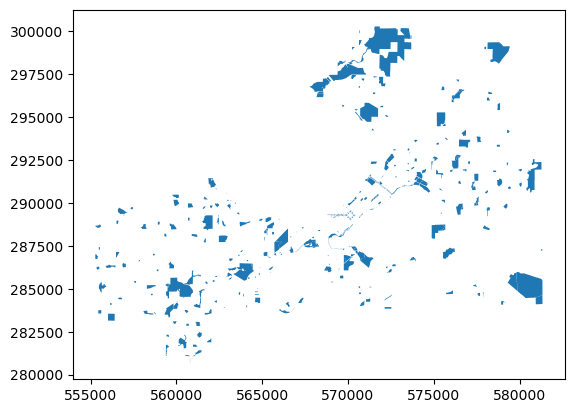

In [14]:
parks.plot()

### easily make a chloropleth map using a selected column as the color (and add a legend) using `plot()`

In [15]:
parks.columns

Index(['OBJECTID', 'Park_ID', 'Type', 'Acreage', 'Park_Name', 'ShortName',
       'Subtype', 'SHAPESTArea', 'SHAPESTLength', 'geometry'],
      dtype='object')

In [16]:
parks.sample(4)

OBJECTID Park_ID          Type    Acreage           Park_Name  \
200      6620    3340  NEIGHBORHOOD  15.010000  Thousand Oaks Park   
213      6633    1730    OPEN SPACE  16.889999         Quarry Park   
60       6476    3170    OPEN SPACE   4.860000  Nesbitt Open Space   
242      6662    1830     COMMUNITY  37.070000       Marshall Park   

         ShortName Subtype   SHAPESTArea  SHAPESTLength  \
200  Thousand Oaks    None  6.538436e+05    5241.141025   
213         Quarry    None  7.359288e+05    3788.202174   
60         Nesbitt    None  2.115851e+05    5273.582552   
242       Marshall    None  1.614843e+06    6918.141753   

                                              geometry  
200  POLYGON ((555883.719 286336.479, 555881.337 28...  
213  POLYGON ((565526.761 289179.164, 565511.442 28...  
60   MULTIPOLYGON (((560767.626 281070.62, 560768.6...  
242  POLYGON ((562217.026 291215.234, 562212.234 29...

<Axes: >

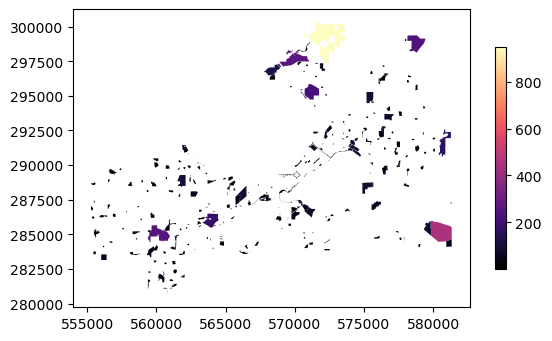

In [17]:
parks.plot(column="Acreage", cmap = 'magma', k=5, legend=True, legend_kwds={'shrink': 0.6})

### also a very cool interactive plot options with a basemap using `explore()`

In [18]:
parks.explore(column='Acreage', cmap='magma')

### we can read in another shapefile

In [19]:
hoods = gp.read_file(datapath / 'Neighborhood_Associations.geojson')

In [20]:
hoods.sample(5)

OBJECTID  NA_ID                                NEIGHB_NAME    STATUS  \
128      9975    125                         High Point Estates  Inactive   
114      9961     79   Schenk-Atwood Revitalization Association    Active   
83       9930    110  Worthington Park Neighborhood Association    Active   
26       9873     32         Greenbush Neighborhood Association    Active   
18       9865     22          East Bluff Homeowners Association    Active   

                   CLASSIFICA  \
128  Neighborhood Association   
114      Business Association   
83   Neighborhood Association   
26   Neighborhood Association   
18    Condominium Association   

                                                   Web   ShapeSTArea  \
128  http://www.cityofmadison.com/neighborhoods/pro...  6.337130e+06   
114  http://www.cityofmadison.com/neighborhoods/pro...  1.564106e+07   
83   http://www.cityofmadison.com/neighborhoods/pro...  4.286243e+06   
26   http://www.cityofmadison.com/neighborhoods/pro...  7.792572e+06   
18   http://www.cityofmadison.com/neighborhoods/pro...  6.502308e+05   

     ShapeSTLength                                           geometry  
128   13117.136629  POLYGON ((-89.51383 43.04733, -89.51383 43.047...  
114   18286.735423  POLYGON ((-89.34151 43.09711, -89.34168 43.097...  
83     9627.233998  POLYGON ((-89.33066 43.10552, -89.33063 43.106...  
26    11923.094370  POLYGON ((-89.40005 43.05842, -89.40011 43.058...  
18     3345.493777  POLYGON ((-89.3635 43.1312, -89.36347 43.13194...

### and we can plot these on top of each other

<Axes: >

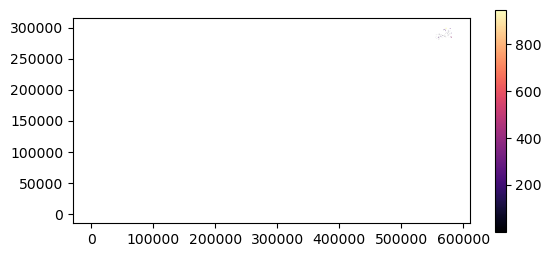

In [21]:
ax_hood = hoods.plot()
# now plot the other one but specify which axis to plot on (ax=ax_hood)
parks.plot(column="Acreage", cmap = 'magma', k=5, legend=True, legend_kwds={'shrink': 0.6}, ax=ax_hood)

### WAT! Why so far apart?

In [22]:
hoods.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

### we need to reproject. Geopandas uses `to_crs()` for this purpose

In [23]:
# we can reproject, and set hoods to park crs 
hoods.to_crs(parks.crs, inplace=True)

<Axes: >

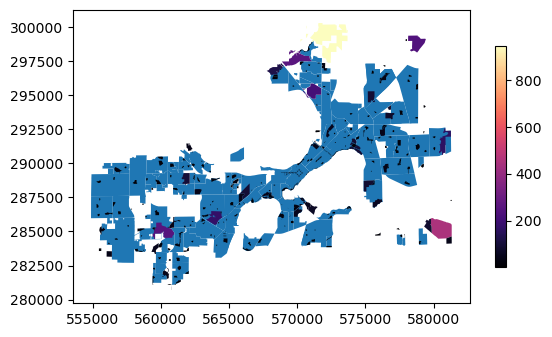

In [24]:
ax_hood = hoods.plot()
# now plot the other one but specify which axis to plot on (ax=ax_hood)
parks.plot(column="Acreage", cmap = 'magma', k=5, legend=True, legend_kwds={'shrink': 0.6}, ax=ax_hood)

### or similarly with the interactive maps

In [25]:
m_hood = hoods.explore()
parks.explore(column="Acreage", cmap = 'magma', k=5, legend=True, legend_kwds={'shrink': 0.6}, m=m_hood)

### we can make a new geodataframe using shapely properties of the geometry - how about centroids?

## TEST YOUR SKILLS #0
- make a new geodataframe of the parks
- add a columns with centroids for each park
- plot an interactive window with the park centroids and the neighborhoods
- hints: 
    - remember the shapely methods are available for each geometry object (e.g. `centroid()`) 
    - you can loop over the column in a couple different ways
    - you can define which columns contains the geometry of a geodataframe
    - you will likely have to define the CRS

## GEOSPATIAL OPERATIONS
***

### Operations on and among geodataframes...do I need to use a GIS program?

### Dissolve

In [26]:
hoods.dissolve() # note it defaults to filling all the columns with the first value

geometry  OBJECTID  NA_ID  \
0  MULTIPOLYGON (((560429.904 281602.442, 560430....      9847      1   

                                    NEIGHB_NAME  STATUS  \
0  Allied Dunn's Marsh Neighborhood Association  Active   

                 CLASSIFICA  \
0  Neighborhood Association   

                                                 Web   ShapeSTArea  \
0  http://www.cityofmadison.com/neighborhoods/pro...  1.512568e+07   

   ShapeSTLength  
0   16657.055614

<Axes: >

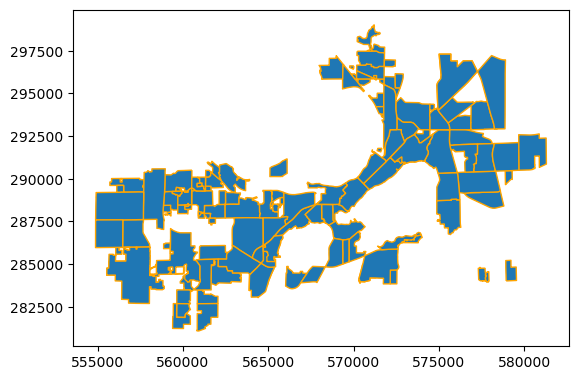

In [27]:
ax=hoods.dissolve().plot()
hoods.plot(facecolor=None, edgecolor='orange', ax=ax)

### Convex Hull

<Axes: >

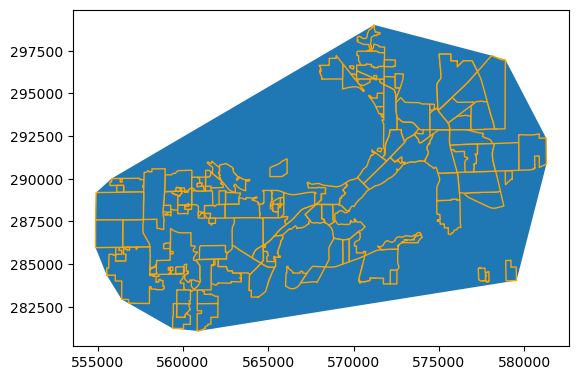

In [28]:
ax = hoods.dissolve().convex_hull.plot()
hoods.plot(facecolor=None, edgecolor='orange', ax=ax)

### Bounding Box is a little more tricky

In [29]:
hoods.bounds # that's per each row

minx           miny           maxx           maxy
0    563872.429544  283460.518859  565328.837226  285057.462675
1    561310.621737  289288.751579  561646.281647  289570.375291
2    566010.016502  283558.607236  567270.271941  284869.636703
3    568527.624082  286423.950486  570669.728818  287657.510073
4    569018.771979  288242.314399  569250.882412  288506.627088
..             ...            ...            ...            ...
135  574180.047766  290323.744701  576068.029053  292858.768636
136  572143.872431  290896.914666  574663.138190  292637.318811
137  554878.971311  287588.991000  557696.123932  289229.663701
138  567269.204147  288485.712034  569627.785405  289802.439174
139  554873.114600  285970.029005  556474.561414  287596.015566

[140 rows x 4 columns]

In [30]:
tb = hoods.total_bounds # this gives overall bounds
tb

array([554873.11459994, 281085.59466762, 581291.42545321, 299016.88496873])

### We can make a polygon from these coordinates with `shapely`

In [31]:
from shapely.geometry import box

In [32]:
bbox = box(tb[0], tb[1], tb[2], tb[3])
# pro tip - when passing a bunch of ordered arguments, '*' will unpack them #nice
bbox = box(*hoods.total_bounds)

#### to make a GeoDataFrame from scratch, the minimum you need is geometry, but a crs is important, and some data will populate more columns

In [33]:

hoods_boundary = gp.GeoDataFrame(data={'thing':['bounding_box']},geometry=[bbox], crs=hoods.crs)
hoods_boundary

thing                                           geometry
0  bounding_box  POLYGON ((581291.425 281085.595, 581291.425 29...

<Axes: >

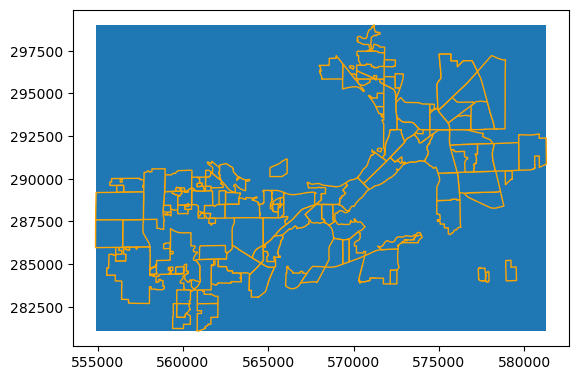

In [34]:
ax = hoods_boundary.plot()
hoods.plot(facecolor=None, edgecolor='orange', ax=ax)

### How about some spatial joins?

#### we can bring in information based on locational overlap. Let's look at just a couple neighborhoods (Marquette and Tenny-Lapham) on the Isthmus

In [35]:
isthmus = hoods.loc[hoods['NEIGHB_NAME'].str.contains('Marquette') | 
                   hoods['NEIGHB_NAME'].str.contains('Tenney')]
isthmus

OBJECTID  NA_ID                             NEIGHB_NAME  STATUS  \
40      9887     49      Marquette Neighborhood Association  Active   
68      9915     92  Tenney-Lapham Neighborhood Association  Active   

                  CLASSIFICA  \
40  Neighborhood Association   
68  Neighborhood Association   

                                                  Web   ShapeSTArea  \
40  http://www.cityofmadison.com/neighborhoods/pro...  1.973684e+07   
68  http://www.cityofmadison.com/neighborhoods/pro...  1.333260e+07   

    ShapeSTLength                                           geometry  
40   23274.760528  POLYGON ((572818.456 291044.343, 572821.978 29...  
68   18614.467212  POLYGON ((571192.747 291561.285, 571106.236 29...

In [36]:
isthmus.explore()

In [37]:
isthmus.sjoin(parks).explore()

In [38]:
parks.sjoin(isthmus).explore()

#### so, it matters which direction you join from. The geometry is preserved from the dataframe "on the left"
#### equivalently, you can be more explicit in calling `sjoin`

In [39]:
gp.sjoin(left_df=parks, right_df=isthmus).explore()

In [40]:
isthmus_parks = gp.sjoin(left_df=parks, right_df=isthmus)

#### we are going to use this `isthmus_parks` geoDataFrame a little later, but we want to trim out some unneeded and distracting columns. We can use `.drop()` just like with a regular Pandas DataFrame

In [41]:
isthmus_parks.columns

Index(['OBJECTID_left', 'Park_ID', 'Type', 'Acreage', 'Park_Name', 'ShortName',
       'Subtype', 'SHAPESTArea', 'SHAPESTLength', 'geometry', 'index_right',
       'OBJECTID_right', 'NA_ID', 'NEIGHB_NAME', 'STATUS', 'CLASSIFICA', 'Web',
       'ShapeSTArea', 'ShapeSTLength'],
      dtype='object')

In [42]:
isthmus_parks.drop(columns=[ 'index_right','OBJECTID_right', 'NA_ID', 
       'STATUS', 'CLASSIFICA', 'Web',
       'ShapeSTArea', 'ShapeSTLength'], inplace=True)

### Let's explore the various predicates with a small intersecting box

<Axes: >

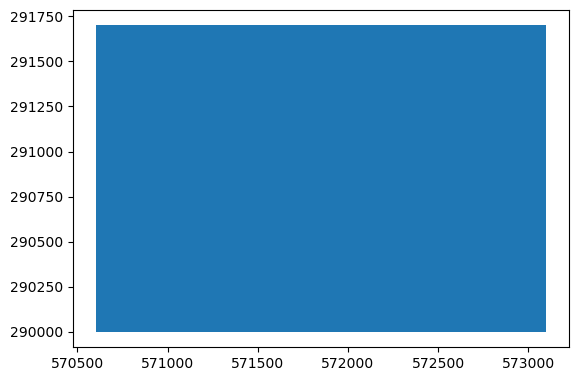

In [43]:
bbox = box(570600, 290000, 573100, 291700)
bounds = gp.GeoDataFrame(geometry=[bbox],crs=parks.crs)
bounds.plot()

#### See [documentation](https://shapely.readthedocs.io/en/latest/manual.html#binary-predicates) for full set of options for predicates. We'll just check out a couple options: `intersects`, `contains`, `within`

## TEST YOUR SKILLS #1
Using the `bounds` geodataframe you just made, write a function to visualize predicate behaviors.
- your function should accept a left geodataframe, a right geodataframe, and a string for the predicate
- your function should plot:
    - the left geodataframe in (default) blue
    - the result of the spatial join operation in another color
    - the right geodataframe in another color with outline only
- then you should set the title of the plot to the string predicate value used
- the geodataframes to test with are `isthmus_parks` and `bounds`
- your function should `return` the joined geodataframe

- a couple hints:
    - in the `plot` method are a couple args called `facecolor` and `edgecolor` that will help plot the rectangle
    - there are other predicates to try out 

- _advanced options_: if that was easy, you can try a couple other things like:
    - explore joins with points and lines in addition to just polygons
    - change around the `bounds` polygon dimensions 
    - use `explore()` to make an interactive map

#### Spatial joins are particularly useful with collections of points. A common case is to add a polygon attribute to points falling within each polygon. Let's check out a bigger point dataset with all the trees on streets in Madison

/home/runner/micromamba/envs/pyclass-docs/lib/python3.11/site-packages/pyogrio/raw.py:198: RuntimeWarning: driver GeoJSON does not support open option INDEX_COL
  return ogr_read(


<Axes: >

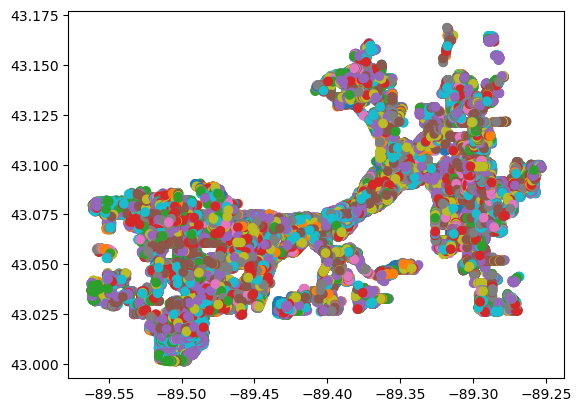

In [44]:
trees = gp.read_file(datapath / 'Street_Trees.geojson', index_col=0)
trees.plot(column='SPECIES')

#### let's put this into the same crs as neighborhoods and join the data together so we can have a neighborhood attribute on the trees geodataframe

In [45]:
trees.to_crs(hoods.crs, inplace=True)

In [46]:
hoods.columns

Index(['OBJECTID', 'NA_ID', 'NEIGHB_NAME', 'STATUS', 'CLASSIFICA', 'Web',
       'ShapeSTArea', 'ShapeSTLength', 'geometry'],
      dtype='object')

#### NOTE: if we pass only some columns of the GeoDataFrame, only those columns will be included in the result, which is cool. _But_ - must include the active geometry column as well!

In [47]:
trees_with_hoods = trees[['SPECIES','DIAMETER','geometry']].sjoin(hoods[['NEIGHB_NAME','geometry']])
trees_with_hoods

SPECIES  DIAMETER                       geometry  index_right  \
0          554      22.0  POINT (569406.122 285635.225)            6   
1          554      20.0  POINT (569391.615 285635.545)            6   
2          320      14.0  POINT (569383.333 285772.643)            6   
3          320      20.0  POINT (569407.725 285782.686)            6   
4          320      20.0  POINT (569431.459 285792.707)            6   
...        ...       ...                            ...          ...   
112506     462       2.0  POINT (560220.817 289224.439)           79   
112507     804       2.0  POINT (560124.192 289029.458)           73   
112508     734       2.0  POINT (559632.848 288907.214)           58   
112509     804       2.0  POINT (559630.291 288945.507)           58   
112510     734       2.0  POINT (559988.837 288833.319)           73   

                                     NEIGHB_NAME  
0       Bram's Addition Neighborhood Association  
1       Bram's Addition Neighborhood Association  
2       Bram's Addition Neighborhood Association  
3       Bram's Addition Neighborhood Association  
4       Bram's Addition Neighborhood Association  
...                                          ...  
112506  Wexford Village Condominium Owners Assoc  
112507       Walnut Grove Homeowners Association  
112508       Sauk Creek Neighborhood Association  
112509       Sauk Creek Neighborhood Association  
112510       Walnut Grove Homeowners Association  

[108937 rows x 5 columns]

#### now we can do a `groupby`, for example, to find things like the average or max diameter of trees in each neighborhood

<Axes: xlabel='NEIGHB_NAME'>

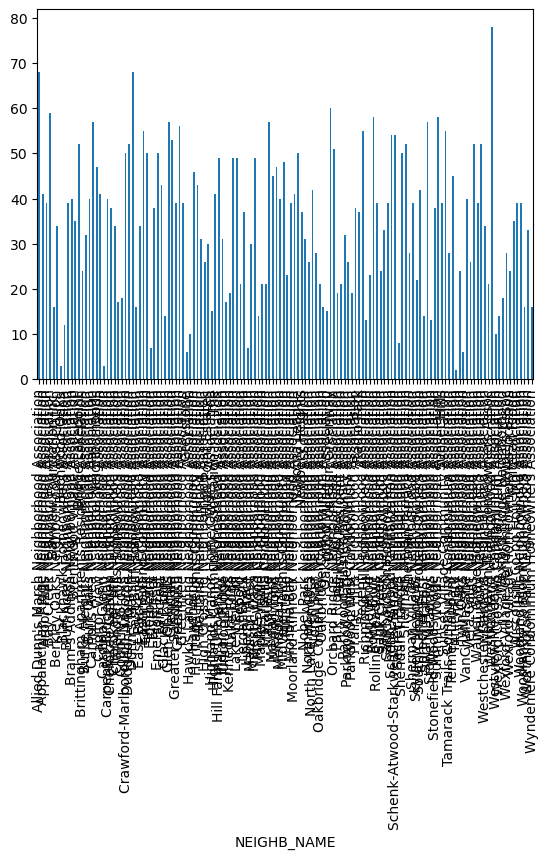

In [48]:
trees_with_hoods.groupby('NEIGHB_NAME')['DIAMETER'].max().plot(kind='bar')

#### We could rearrange that bar chart in various ways, but we can also flip this back to the original neighborhoods GeoDataFrame to make a more useful spatial plot. Note that we used the spatial join to join together the attribute "Neighborhood Name" with each tree point. But now, we can aggregate those results and assign them based on an attribute rather than geospatially just like regular Pandas DataFrames

In [49]:
hood_trees = hoods.copy()
tree_summary = trees_with_hoods.groupby('NEIGHB_NAME')['DIAMETER'].max()
hood_trees.merge(tree_summary,
                left_on = 'NEIGHB_NAME', right_on='NEIGHB_NAME').explore(column="DIAMETER")

## TEST YOUR SKILLS _OPTIONAL_
We have an Excel file that contains a crosswalk between SPECIES number as provided and species name. Can we bring that into our dataset and evaluate some conclusions about tree species by neighborhood?
- start with the `trees_with_hoods` GeoDataFrame
- load up and join the data from datapath / 'Madison_Tree_Species_Lookup.xlsx'
- hint: check the dtypes before merging - if you are going to join on a column, the column must be the same dtype in both dataframes
- Make a multipage PDF with a page for each neighborhood showing a bar chart of the top ten tree species (by name) in each neighborhood
- Make a map (use explore, or save to SHP or geojson) showing the neighborhoods with a color-coded field showing the most common tree species for each neighborhood

You will need a few pandas operations that we have only touched on a bit:  

`groupby`, `count`, `merge`, `read_excel`, `sort_values`, `iloc`

#### As we've seen, spatial joins are powerful, but they really only gather data from multiple collections. What if we want to actually calculate the amount of overlap among shapes? Or create new shapes based on intersection or not intersection of shapes? [`overlay`](https://geopandas.org/en/stable/docs/user_guide/set_operations.html?highlight=overlay) does these things.

#### main options are `intersection`, `difference`, `union`, and `symmetric_difference`

<Axes: >

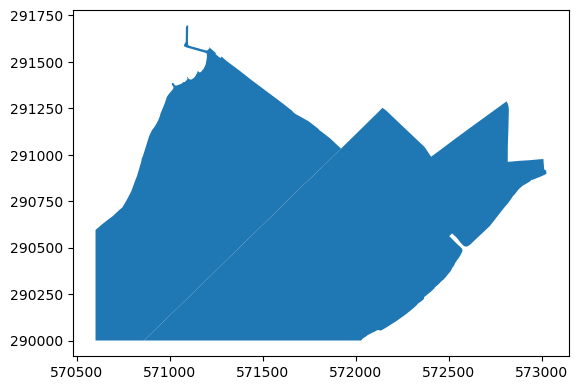

In [50]:
inters = bounds.overlay(isthmus, how='intersection')
inters.plot()

In [51]:
inters

OBJECTID  NA_ID                             NEIGHB_NAME  STATUS  \
0      9887     49      Marquette Neighborhood Association  Active   
1      9915     92  Tenney-Lapham Neighborhood Association  Active   

                 CLASSIFICA  \
0  Neighborhood Association   
1  Neighborhood Association   

                                                 Web   ShapeSTArea  \
0  http://www.cityofmadison.com/neighborhoods/pro...  1.973684e+07   
1  http://www.cityofmadison.com/neighborhoods/pro...  1.333260e+07   

   ShapeSTLength                                           geometry  
0   23274.760528  POLYGON ((570860.48 290000, 570864.33 290003.7...  
1   18614.467212  POLYGON ((570600 290000, 570600 290594.312, 57...

<Axes: >

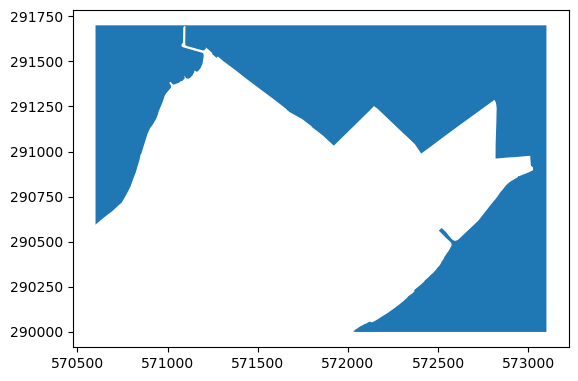

In [52]:
differ = bounds.overlay(isthmus, how='difference')
differ.plot()

In [53]:
differ

geometry
0  POLYGON ((570600 291700, 573100 291700, 573100...

<Axes: >

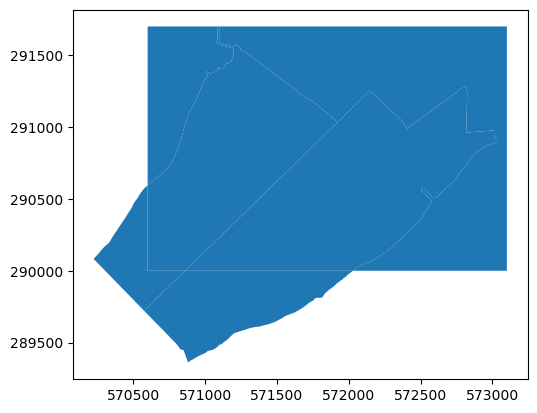

In [54]:
unite = bounds.overlay(isthmus, how='union')
unite.plot()

In [55]:
unite

OBJECTID  NA_ID                             NEIGHB_NAME  STATUS  \
0    9887.0   49.0      Marquette Neighborhood Association  Active   
1    9915.0   92.0  Tenney-Lapham Neighborhood Association  Active   
2       NaN    NaN                                     NaN     NaN   
3    9887.0   49.0      Marquette Neighborhood Association  Active   
4    9915.0   92.0  Tenney-Lapham Neighborhood Association  Active   

                 CLASSIFICA  \
0  Neighborhood Association   
1  Neighborhood Association   
2                       NaN   
3  Neighborhood Association   
4  Neighborhood Association   

                                                 Web   ShapeSTArea  \
0  http://www.cityofmadison.com/neighborhoods/pro...  1.973684e+07   
1  http://www.cityofmadison.com/neighborhoods/pro...  1.333260e+07   
2                                                NaN           NaN   
3  http://www.cityofmadison.com/neighborhoods/pro...  1.973684e+07   
4  http://www.cityofmadison.com/neighborhoods/pro...  1.333260e+07   

   ShapeSTLength                                           geometry  
0   23274.760528  POLYGON ((570860.48 290000, 570864.33 290003.7...  
1   18614.467212  POLYGON ((570600 290000, 570600 290594.312, 57...  
2            NaN  POLYGON ((570600 291700, 573100 291700, 573100...  
3   23274.760528  POLYGON ((572028.3 289999.01, 572016.817 28999...  
4   18614.467212  POLYGON ((570717.845 289861.621, 570574.454 28...

<Axes: >

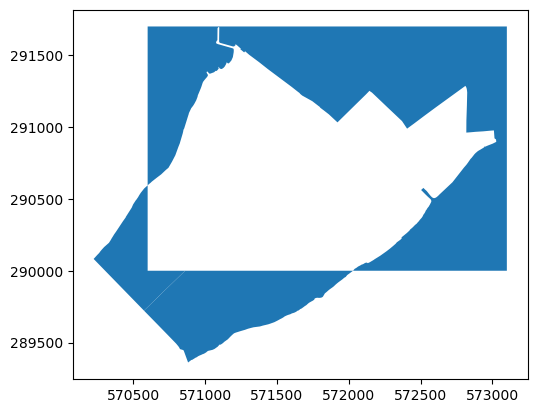

In [56]:
symdiff = bounds.overlay(isthmus, how='symmetric_difference')
symdiff.plot()

In [57]:
symdiff

OBJECTID  NA_ID                             NEIGHB_NAME  STATUS  \
0       NaN    NaN                                     NaN     NaN   
1    9887.0   49.0      Marquette Neighborhood Association  Active   
2    9915.0   92.0  Tenney-Lapham Neighborhood Association  Active   

                 CLASSIFICA  \
0                       NaN   
1  Neighborhood Association   
2  Neighborhood Association   

                                                 Web   ShapeSTArea  \
0                                                NaN           NaN   
1  http://www.cityofmadison.com/neighborhoods/pro...  1.973684e+07   
2  http://www.cityofmadison.com/neighborhoods/pro...  1.333260e+07   

   ShapeSTLength                                           geometry  
0            NaN  POLYGON ((570600 291700, 573100 291700, 573100...  
1   23274.760528  POLYGON ((572028.3 289999.01, 572016.817 28999...  
2   18614.467212  POLYGON ((570717.845 289861.621, 570574.454 28...

### On your own...
- what if you switch left and right dataframes?
- how can you evaluate the areas of overlap for the intersection case?